<a href="https://colab.research.google.com/github/portoforigin/deeplearn/blob/main/fastai/PETS_Breed_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Install Dependencies:**

 - Default version of fastai in Google Colab is 1.0.61(?), we need >v2.2.5

In [ ]:
!pip install -Uqq fastai
!pip install lime

import fastai
fastai.__version__

PROJECT_NAME = "FastAI_PETS"
MODEL_NAME = "fastai_pets_breed_001.pkl"

     |████████████████████████████████| 194kB 12.8MB/s 
     |████████████████████████████████| 61kB 7.0MB/s 
     |████████████████████████████████| 276kB 13.2MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283846 sha256=e72a36d9e582de370afd417149270e874756bba7651ed48021a4e309bd0fc11b
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


## **PETS Dataset**

Load a view the PETS dataset:

There are 7390 images


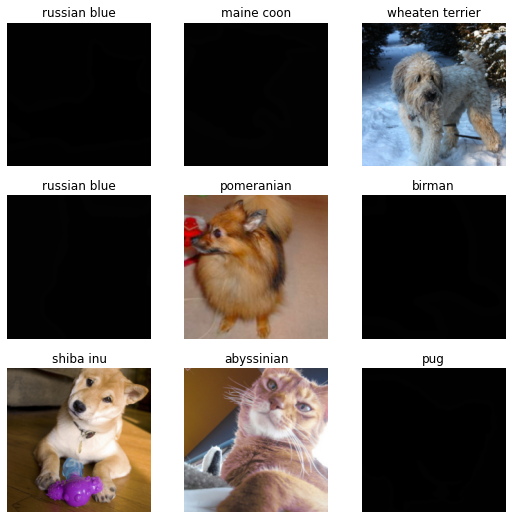

In [ ]:
from fastai.vision.all import *

path = untar_data(URLs.PETS)
# path.ls()

files = get_image_files(path/"images")
print("There are %s images" % (len(files)))

# Label Function
# - Capital first letter indicates Cat
def label_func(f):
  breed = " ".join(f.split("_")[0:-1]).lower()
  return breed
  
# Load Data set
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=label_func, 
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75),
    metrics=error_rate)

dls.show_batch()

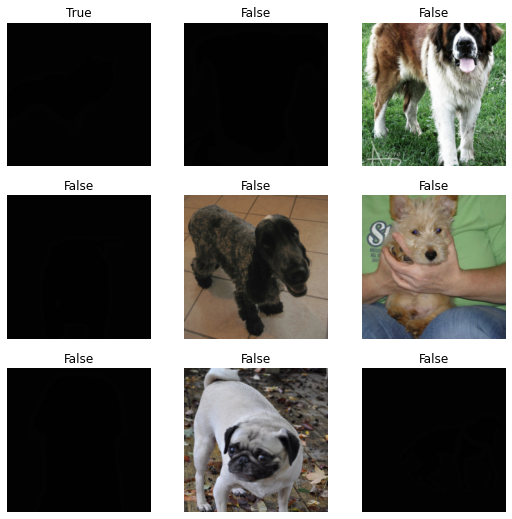

In [ ]:
def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))


dls.show_batch()

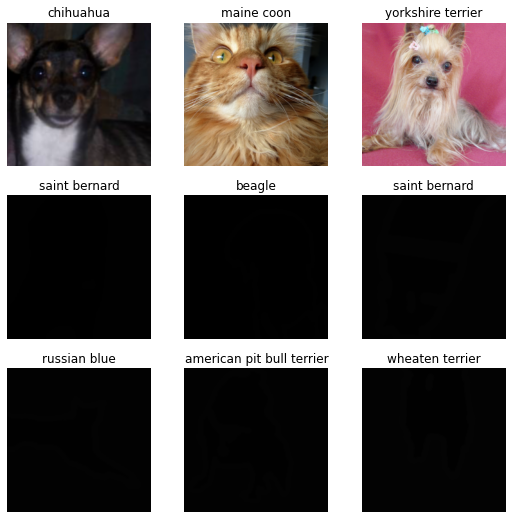

In [ ]:
# View Data set (True == Cat, False == Dog)
dls.show_batch()

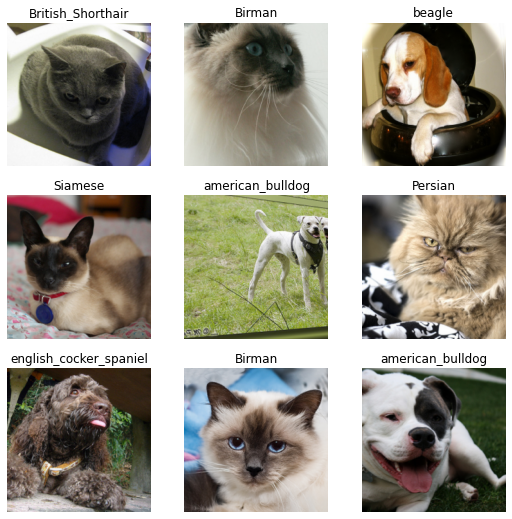

In [ ]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460, 460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

dls.show_batch()

## **Generate Fast AI Model for identifying Cat/Dog Breeds**

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


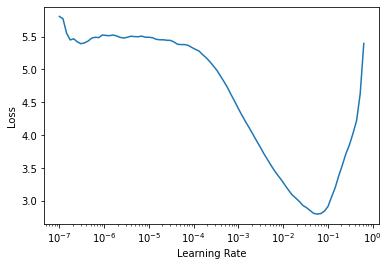

In [ ]:
learn = cnn_learner(dls, resnet101, metrics=error_rate).to_fp16()
lr_min,lr_steep = learn.lr_find()



In [ ]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 5.75e-03, steepest point: 5.75e-04


In [ ]:
learn.fine_tune(6, base_lr=5e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.735051,0.323604,0.105548,01:09


epoch,train_loss,valid_loss,error_rate,time
0,0.462061,0.458150,0.133965,01:15
1,0.617431,0.988951,0.207037,01:15
2,0.508091,0.464985,0.131258,01:15
3,0.302150,0.294722,0.089986,01:15
4,0.148166,0.208423,0.066306,01:15
5,0.084035,0.205130,0.062923,01:15


In [ ]:
learn.fine_tune(6, base_lr=1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.070847,nan,0.277402,01:11


epoch,train_loss,valid_loss,error_rate,time
0,1.066615,nan,0.271989,01:15
1,1.040141,nan,0.267253,01:15
2,0.996592,nan,0.262517,01:15
3,0.954628,nan,0.261164,01:15
4,0.955934,nan,0.252368,01:15
5,0.948136,nan,0.261840,01:15


In [ ]:
learn.fine_tune(6, base_lr=1e-2)

epoch,train_loss,valid_loss,error_rate,time
0,0.194211,0.563004,0.095399,01:10


epoch,train_loss,valid_loss,error_rate,time
0,0.434823,1.238831,0.234100,01:15
1,0.968516,1.004353,0.238160,01:15
2,0.709491,0.743107,0.193505,01:15
3,0.434102,0.419278,0.119756,01:15
4,0.212909,0.269987,0.080514,01:15
5,0.125456,0.248801,0.075101,01:15


In [ ]:
learn.fine_tune(6, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,3.112801,16.823456,0.672530,01:10


epoch,train_loss,valid_loss,error_rate,time
0,5.174484,100.452446,0.879567,01:15
1,3.261821,78.068138,0.740866,01:15
2,2.936068,nan,0.917456,01:15
3,2.273641,nan,0.480379,01:15
4,1.666199,nan,0.358593,01:15
5,1.217472,nan,0.277402,01:15


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=5)

In [ ]:
#learn101 = cnn_learner(dls, resnet101, metrics=error_rate)
#learn101.fine_tune(5)

## **Evaulate Model**

In [ ]:
#Print top losses. 
interp = ClassificationInterpretation.from_learner(learn)

[1] /root/.fastai/data/oxford-iiit-pet/images/american_bulldog_62.jpg
[2] /root/.fastai/data/oxford-iiit-pet/annotations/trimaps/havanese_82.png
[3] /root/.fastai/data/oxford-iiit-pet/annotations/trimaps/boxer_146.png
[4] /root/.fastai/data/oxford-iiit-pet/annotations/trimaps/Persian_128.png
[5] /root/.fastai/data/oxford-iiit-pet/images/chihuahua_85.jpg


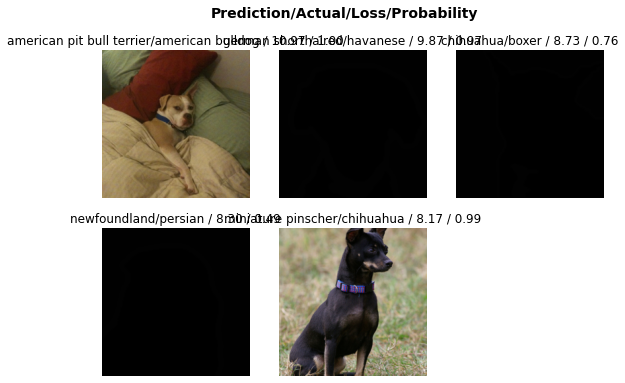

In [ ]:
num_losses = 5
losses, indices = interp.top_losses(num_losses)
x = 1
for idx in indices:
    print(f"[{x}] {dls.valid_ds.items[idx]}")
    x += 1
interp.plot_top_losses(num_losses)

## **Upload Test Image**

In [ ]:
'''
from google.colab import files
uploaded = files.upload()
'''

'\nfrom google.colab import files\nuploaded = files.upload()\n'

In [ ]:
'''
import cv2
import numpy as np
from matplotlib import pyplot as plt

for fname in uploaded.keys():
  is_cat,_,probs = learn_species.predict(fname)

  # Show Image
  img = cv2.imread(fname)
  img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img_cvt)
  plt.show()

  print(f"Is %s a cat?: %s" % (fname, is_cat))
  print(f"Probability it's a cat: {probs[1].item():.6f}")
'''

'\nimport cv2\nimport numpy as np\nfrom matplotlib import pyplot as plt\n\nfor fname in uploaded.keys():\n  is_cat,_,probs = learn_species.predict(fname)\n\n  # Show Image\n  img = cv2.imread(fname)\n  img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)\n  plt.imshow(img_cvt)\n  plt.show()\n\n  print(f"Is %s a cat?: %s" % (fname, is_cat))\n  print(f"Probability it\'s a cat: {probs[1].item():.6f}")\n'

## **Save Model to Drive**

**Load pre-trained Model**
Note: All custom functions need to be defined before calling load_leaner() (i.e. `def label_func`)

In [ ]:
#print(f"Loading Model from {dest/MODEL_NAME}")
#learn = load_learner(dest/MODEL_NAME+".pkl")


In [ ]:
'''
from fastai.vision.all import *
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'deeplearn/'
dest=Path(base_dir + PROJECT_NAME)
try:
  dest.mkdir(parents=True, exist_ok=False)
except FileExistsError:
  print ('File Already Exists')
  
learn.export(dest/MODEL_NAME+".pkl")
'''